# Mars Surface and Curiosity Image Classification
### Using a convolutional neural network

by Zachary Pruessner, for Springboard Final submission

**Dataset DOI**

10.5281/zenodo.1049137

**Scientific Paper with additional details on the data** 

Kiri L. Wagstaff, You Lu, Alice Stanboli, Kevin Grimes, Thamme Gowda,
and Jordan Padams. "Deep Mars: CNN Classification of Mars Imagery for
the PDS Imaging Atlas." Proceedings of the Thirtieth Annual Conference
on Innovative Applications of Artificial Intelligence, 2018.


### Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Image Processing
import cv2
import matplotlib.image as mpimg

# Transformations
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Metrics
from tensorflow.keras.metrics import MeanAbsoluteError, Precision, Recall

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

### Loading Data

In [2]:
mars = pd.read_csv('../data/mars_merged.csv')
mars.head()

JPG  LABELS
0  ../data/images/0077ML0005780000102730I01_DRCL.JPG      15
1  ../data/images/0072MR0005610170103642E01_DRCL.JPG       8
2  ../data/images/0069MR0004130000103477I01_DRCL.JPG      21
3  ../data/images/0154ML0008510010104492E01_DRCL.JPG       8
4  ../data/images/0019MR0000530000100138C00_DRCL.JPG       8

In [3]:
# Label dictionary

values = ['apxs', 'apxs cal target', 'chemcam cal target', 'chemin inlet open',
            'drill', 'drill holes', 'drt front', 'drt side', 'ground', 'horizon',
            'inlet', 'mahli', 'mahli cal target', 'mastcam', 'mastcam cal target',
            'observation tray', 'portion box', 'portion tube', 'portion tube opening',
            'rems uv sensor', 'rover rear deck', 'scoop', 'sun', 'turret', 'wheel']
keys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

label_dict = dict(zip(keys, values))

In [4]:
# setting aside some images to view
mars_labeled = mars.replace({"LABELS": label_dict})

sample_img = mars_labeled['JPG'][:10]
sample_label = mars_labeled['LABELS'][:10]

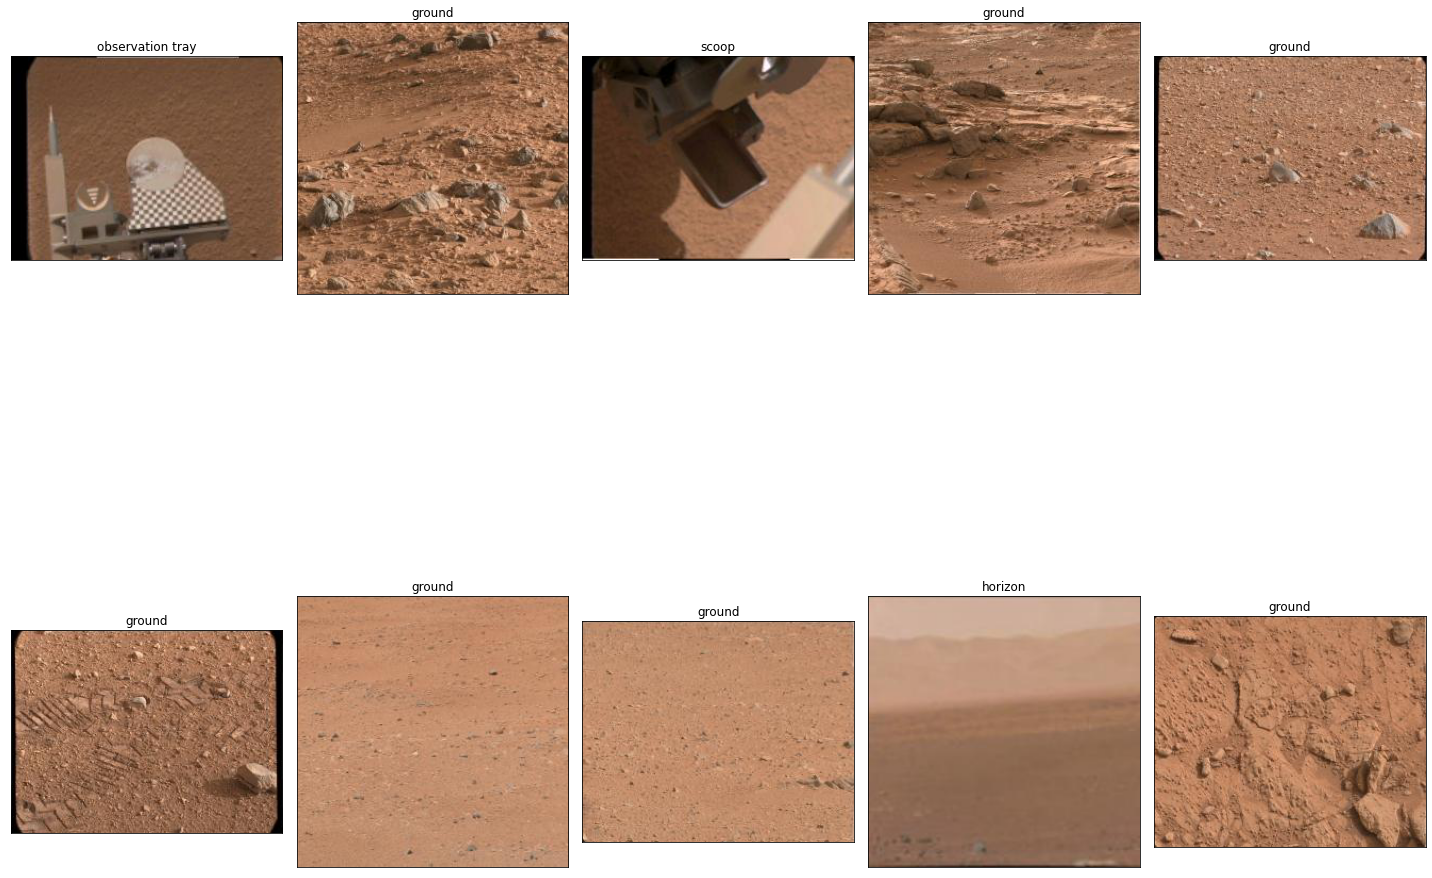

In [5]:
# Visualizing some images
fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})


for i, ax in enumerate(axes.flat):
    ax.imshow(mpimg.imread(sample_img[i]))
    ax.set_title(sample_label[i])
plt.tight_layout()
plt.show()

### Data Split

In [6]:
X_train, X_test = train_test_split(mars, train_size=0.9, random_state=42, shuffle=True, stratify=mars['LABELS'])

# checking shape of train and test split
print(X_train.shape)
print(X_test.shape)

(6021, 2)
(670, 2)


array([[<AxesSubplot:title={'center':'LABELS'}>]], dtype=object)

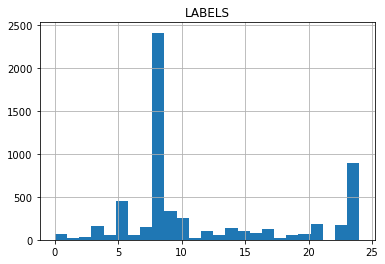

In [7]:
X_train.hist(bins=25)

In [8]:
# Transforming train images
Transformed_X_Train = []
Transformed_X_Train_Labels = []

for image, label in zip(X_train.JPG, X_train.LABELS):
    image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(128,128))
    image = image / 255.0
    Transformed_X_Train.append(image)
    Transformed_X_Train_Labels.append(label)
    
X_Train_Img = np.array(Transformed_X_Train)
X_Train_Labels = to_categorical(Transformed_X_Train_Labels)

# Checking shape
print(X_Train_Img.shape)
print(X_Train_Labels.shape)


# Transforming test images
Transformed_X_Test = []
Transformed_X_Test_Labels = []

for image, label in zip(X_test.JPG, X_test.LABELS):
    image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(128,128))
    image = image / 255.0
    Transformed_X_Test.append(image)
    Transformed_X_Test_Labels.append(label)
    
X_Test_Img = np.array(Transformed_X_Test)
X_Test_Labels = to_categorical(Transformed_X_Test_Labels)

# Checking shape
print(X_Test_Img.shape)
print(X_Test_Labels.shape)

(6021, 128, 128, 3)
(6021, 25)
(670, 128, 128, 3)
(670, 25)


### Model

In [9]:
model_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(25, activation='softmax')
])

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8128576   
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
Total params: 8,131,097
Trainable params: 8,131,097
Non-trainable params: 0
______________________________________________

In [10]:
history_1 = model_1.fit(X_Train_Img, X_Train_Labels, 
                         epochs=7, 
                         batch_size=32,
                         validation_split=0.1)


Epoch 1/7
170/170 [==============================] - 63s 371ms/step - loss: 1.4629 - accuracy: 0.6373 - mae: 0.0415 - val_loss: 0.6791 - val_accuracy: 0.8159 - val_mae: 0.0232
Epoch 2/7
170/170 [==============================] - 67s 394ms/step - loss: 0.5285 - accuracy: 0.8666 - mae: 0.0198 - val_loss: 0.3593 - val_accuracy: 0.9204 - val_mae: 0.0147
Epoch 3/7
170/170 [==============================] - 56s 330ms/step - loss: 0.2942 - accuracy: 0.9251 - mae: 0.0125 - val_loss: 0.2585 - val_accuracy: 0.9453 - val_mae: 0.0108
Epoch 4/7
170/170 [==============================] - 55s 325ms/step - loss: 0.1702 - accuracy: 0.9568 - mae: 0.0079 - val_loss: 0.2455 - val_accuracy: 0.9353 - val_mae: 0.0090
Epoch 5/7
170/170 [==============================] - 54s 320ms/step - loss: 0.1206 - accuracy: 0.9683 - mae: 0.0059 - val_loss: 0.2007 - val_accuracy: 0.9436 - val_mae: 0.0069
Epoch 6/7
170/170 [==============================] - 57s 338ms/step - loss: 0.0821 - accuracy: 0.9808 - mae: 0.0040 - va

In [11]:
model_2 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(25, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [12]:
history_2 = model_2.fit(X_Train_Img, X_Train_Labels, 
                         epochs=7, 
                         batch_size=32,
                         validation_split=0.1)

Epoch 1/7
170/170 [==============================] - 91s 534ms/step - loss: 1.2157 - accuracy: 0.7016 - mae: 0.0346 - val_loss: 0.5498 - val_accuracy: 0.8640 - val_mae: 0.0202
Epoch 2/7
170/170 [==============================] - 90s 532ms/step - loss: 0.2570 - accuracy: 0.9326 - mae: 0.0098 - val_loss: 0.2170 - val_accuracy: 0.9370 - val_mae: 0.0078
Epoch 3/7
170/170 [==============================] - 93s 550ms/step - loss: 0.1370 - accuracy: 0.9627 - mae: 0.0056 - val_loss: 0.1638 - val_accuracy: 0.9668 - val_mae: 0.0047
Epoch 4/7
170/170 [==============================] - 90s 530ms/step - loss: 0.0803 - accuracy: 0.9804 - mae: 0.0032 - val_loss: 0.1476 - val_accuracy: 0.9585 - val_mae: 0.0048
Epoch 5/7
170/170 [==============================] - 86s 509ms/step - loss: 0.0685 - accuracy: 0.9812 - mae: 0.0027 - val_loss: 0.1323 - val_accuracy: 0.9602 - val_mae: 0.0039
Epoch 6/7
170/170 [==============================] - 88s 516ms/step - loss: 0.0758 - accuracy: 0.9803 - mae: 0.0029 - va

In [13]:
model_3 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(25, activation='softmax')
])

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae'])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 128)      

In [14]:
history_3 = model_3.fit(X_Train_Img, X_Train_Labels, 
                         epochs=7, 
                         batch_size=32,
                         validation_split=0.1)

Epoch 1/7
170/170 [==============================] - 109s 641ms/step - loss: 0.9936 - accuracy: 0.7383 - mae: 0.0308 - val_loss: 0.4872 - val_accuracy: 0.8375 - val_mae: 0.0203
Epoch 2/7
170/170 [==============================] - 106s 622ms/step - loss: 0.2539 - accuracy: 0.9312 - mae: 0.0096 - val_loss: 0.1833 - val_accuracy: 0.9619 - val_mae: 0.0060
Epoch 3/7
170/170 [==============================] - 109s 643ms/step - loss: 0.1297 - accuracy: 0.9618 - mae: 0.0052 - val_loss: 0.1542 - val_accuracy: 0.9552 - val_mae: 0.0060
Epoch 4/7
170/170 [==============================] - 107s 629ms/step - loss: 0.1205 - accuracy: 0.9649 - mae: 0.0045 - val_loss: 0.1594 - val_accuracy: 0.9602 - val_mae: 0.0056
Epoch 5/7
170/170 [==============================] - 103s 604ms/step - loss: 0.0842 - accuracy: 0.9773 - mae: 0.0031 - val_loss: 0.1171 - val_accuracy: 0.9685 - val_mae: 0.0040
Epoch 6/7
170/170 [==============================] - 103s 605ms/step - loss: 0.0575 - accuracy: 0.9823 - mae: 0.002

### Model 1 history

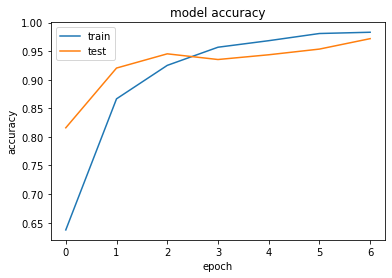

In [15]:
# Plot model 1 accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

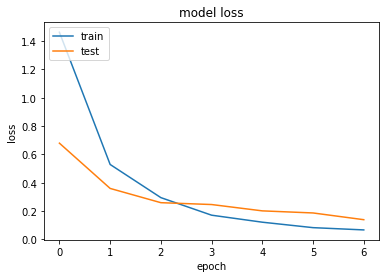

In [16]:
# Plot model 1 loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 2 history

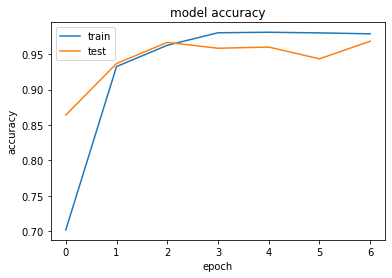

In [17]:
# Plot model 2 accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

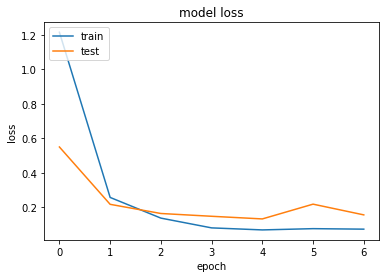

In [18]:
# Plot model 2 loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 3 history

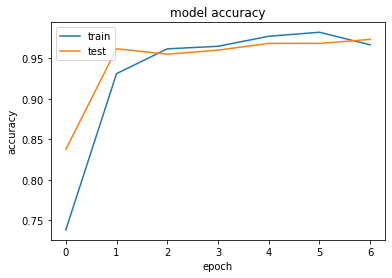

In [19]:
# Plot model 3 accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

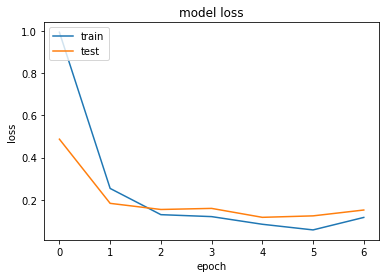

In [20]:
# Plot model 3 loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predictions

In [21]:
# Loading a small portion of the prediction
model_1_pred = model_1(X_Test_Img[0:10])
model_2_pred = model_2(X_Test_Img[0:10])
model_3_pred = model_3(X_Test_Img[0:10])

### Model 1

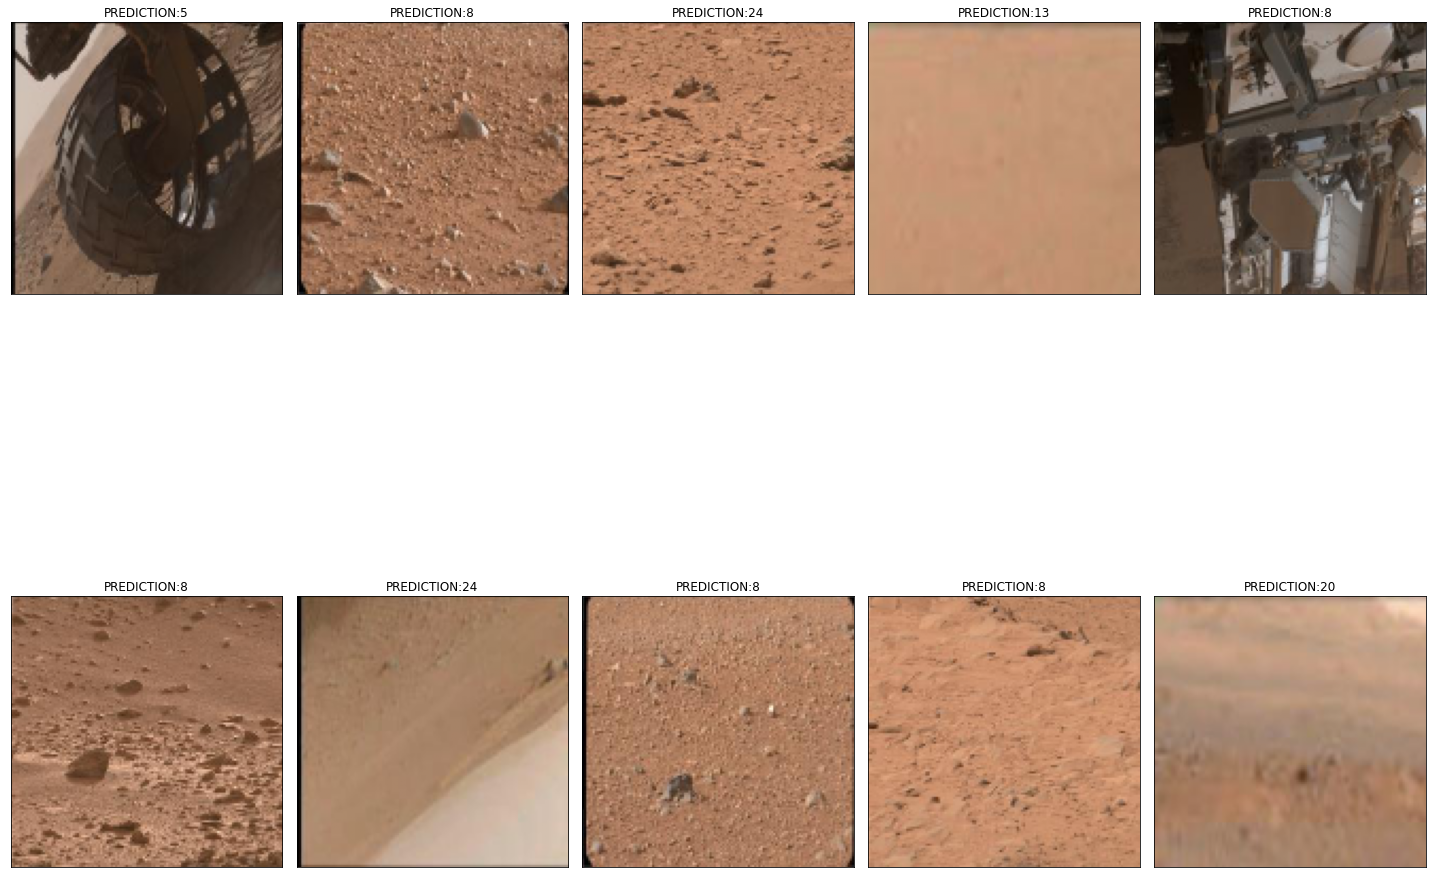

In [22]:
# Visualizing the prediction results model 1
fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Transformed_X_Train[i])
    ax.set_title(f"PREDICTION:{model_1_pred[i].numpy().argmax(axis=-1)}")
plt.tight_layout()
plt.show()

### Model 2

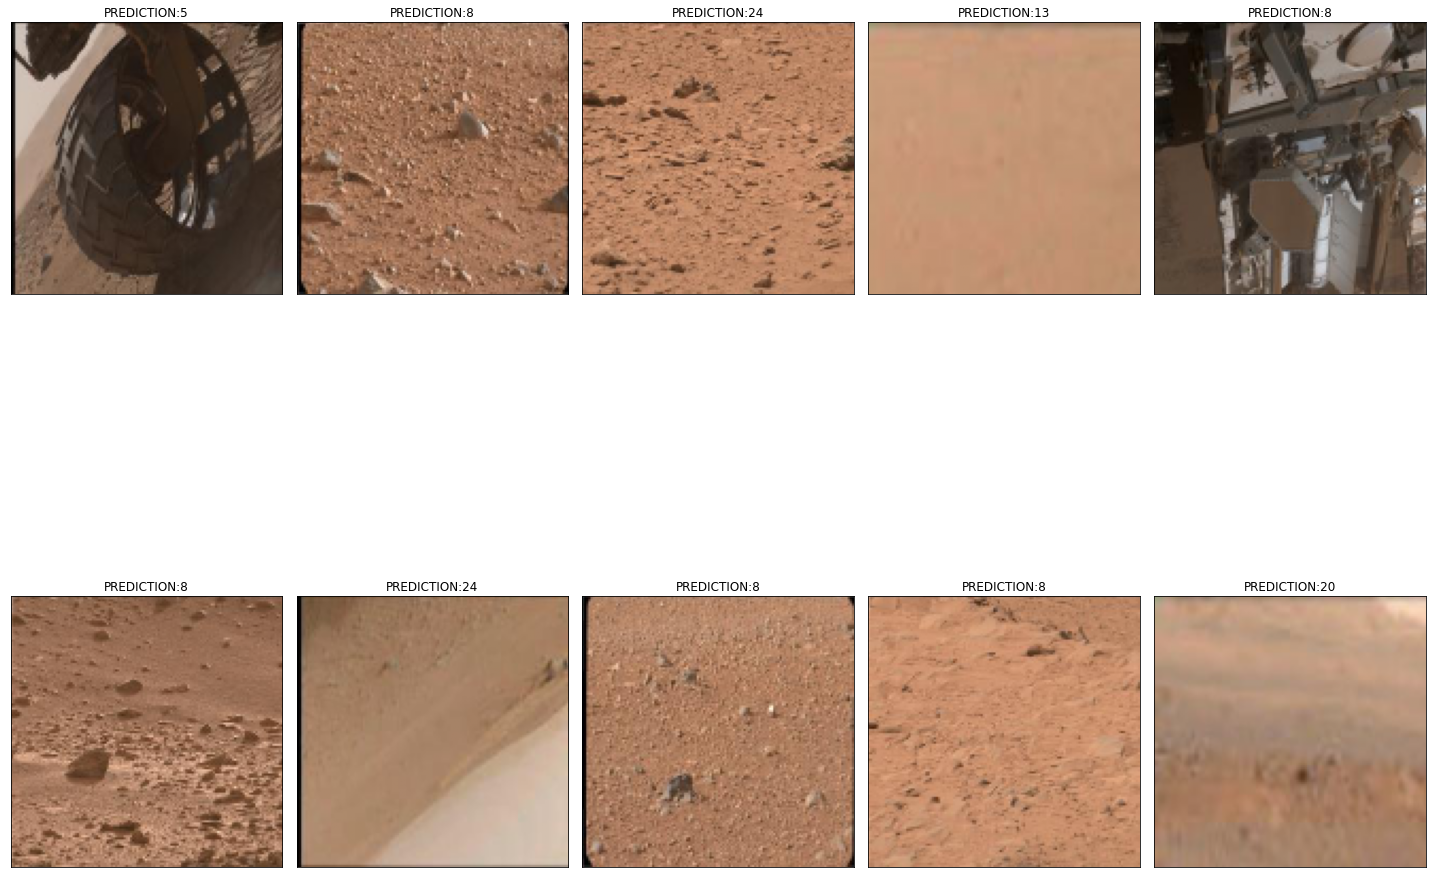

In [23]:
# Visualizing the prediction results model 2
fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Transformed_X_Train[i])
    ax.set_title(f"PREDICTION:{model_2_pred[i].numpy().argmax(axis=-1)}")
plt.tight_layout()
plt.show()

### Model 3

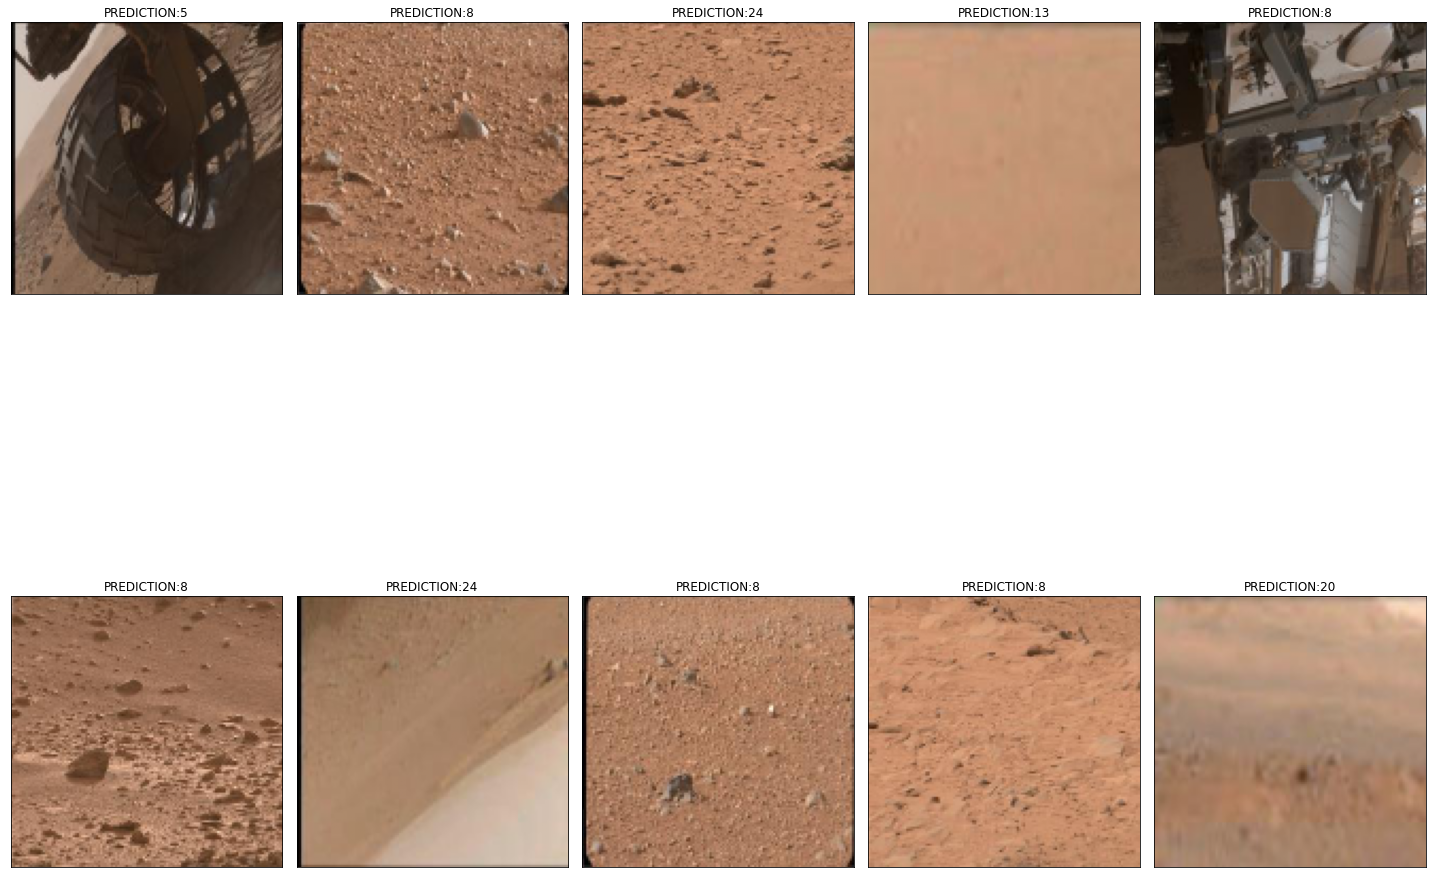

In [24]:
# Visualizing the prediction results model 3
fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Transformed_X_Train[i])
    ax.set_title(f"PREDICTION:{model_3_pred[i].numpy().argmax(axis=-1)}")
plt.tight_layout()
plt.show()

### Prediction Accuracy of Models

In [29]:
def pred(model, imgs, labels):
    #getting predictions
    prediction = model.predict(imgs)
    predicted_labels = prediction.argmax(axis=-1)
    actual_labels = labels.argmax(axis=-1)
    
    # checking difference between prediction and actual
    set_diff = set(actual_labels) - set(predicted_labels)
    list_diff = list(set_diff)
    print(1-(len(list_diff)/len(actual_labels))*100)

In [30]:
print("Model 1: ")
pred(model_1, X_Test_Img, X_Test_Labels)

print("Model 2: ")
pred(model_2, X_Test_Img, X_Test_Labels)

print("Model 3: ")
pred(model_3, X_Test_Img, X_Test_Labels)

Model 1: 
0.8507462686567164
Model 2: 
1.0
Model 3: 
1.0
